# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [2]:
!pip -q install ./python

Invalid requirement: './python'



The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [6]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 1.0


In [7]:
env.close()

When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine!

### First Creating a Neural Network Architecture

Building a simple Feed forward two hidden layer neural network. This architecture would be used for trainnig the agent.

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [8]:
class SimpleQNetwork(nn.Module):
    """Architecture used to train model"""
    
    def __init__(self, state_size, action_size, seed, fc1_units=32, fc2_units=32):
        """Initialize parameters and build model
        Param
        ======
            state_size (int): Dimension of each state
            action_size (int): Total number of actions available
            seed (int): Random seed
            fc1_units (int) : Number of nodes in first hidden layer
            fc2_units (int) : Number of nodes in second hidden layer
        """
        super(SimpleQNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
    def forward(self, state):
        """Build a network that maps state -> action values"""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### Building the Agent

Contains parameters and methods that the agent would contain so that it could work in our environment

In [9]:
import numpy as np
import random
from collections import namedtuple, deque

import torch.optim as optim

In [10]:
BUFFER_SIZE = int(1e5) # replay buffer size
BATCH_SIZE = 64        # minibatch size
GAMMA = 0.99           # discount factor
TAU = 1e-3             # for soft update of target parameters. Used in place of fixed target technique.
LR = 5e-4              # learning rate
UPDATE_EVERY = 4       # how often to update the network

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
class ReplayBuffer:
    """Fixed size buffer to store experience tuples"""
    
    def __init__(self, max_buffer_size, batch_size, seed):
        """Initialize a Replay Buffer Object
        
        Params
        ======
            max_buffer_size (int): maximum size of buffer
            batch_size (int) : size of each training batch
            seed (int) : random seed
        """
        self.memory = deque(maxlen=max_buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory"""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def random_sample(self):
        """Randomly sample a batch of experiences from memory"""
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        """Returns the current size filled in the memory"""
        return len(self.memory)

In [12]:
class Agent():
    """Interacts with and learn from the environment"""
    
    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent Object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): Total number of actions
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        
        # Q Network
        self.local_q_network = SimpleQNetwork(state_size, action_size, seed).to(device)
        self.target_q_network = SimpleQNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.local_q_network.parameters(), lr=LR)
        
        # Replay Memory
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, seed)
        # initialize time step
        self.t_step = 0
        
    def choose_action(self, state, eps=0.):
        """Returns action which should be taken for a current state as per current policy
        
            Params:
            ======
                state (array_like): current state
                eps (float): epsilon for epsilon greedy action selection
        """
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.local_q_network.eval() # first set in eval stage for evaluation of regression values
        with torch.no_grad():
            action_values = self.local_q_network(state)
        self.local_q_network.train() # now that evaluation is finished above revert to train mode
        
        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy()) # return the action having max q value
        else:
            return random.choice(np.arange(self.action_size)) # return any one of the action randomly
        
    def agent_next_step(self, state, action, reward, next_state, done, is_double_q=True):
        """After getting reward, next_state and done status from the environment update agent experience using them"""
        
        # save this new experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.random_sample()
                self.learn(experiences, GAMMA, is_double_q)
    
    def learn(self, experiences, gamma, is_double_q=True):
        """Update value parameters using selected batch of experience tuples.
            
            Params
            ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples
            gamma (float) : discount factor
        """
        
        states, actions, rewards, next_states, dones = experiences
        
        if is_double_q:
            next_actions = self.local_q_network(next_states).detach().argmax(1).unsqueeze(1)
            q_targets_next = self.target_q_network(next_states).gather(1, next_actions)
        else:
            # Get max predicted Q values (for next state) from target model
            q_targets_next = self.target_q_network(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states
        q_targets = rewards + (gamma * q_targets_next * (1 - dones))
        
        # Get expected Q values from local model
        q_expecteds = self.local_q_network(states).gather(1, actions)
        
        # Compute loss
        loss = F.mse_loss(q_expecteds, q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        ## Update target network softly ##
        self.soft_update(self.local_q_network, self.target_q_network, TAU)
        
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

### Train the Agent

In [14]:
agent = Agent(state_size, action_size, 7)

In [15]:
def train_agent(n_episodes=2000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Train an agent by iterating episodes
        Params
        ======
            n_episodes (int): maximum number of training episodes
            eps_start (float): starting value of epsilon, for epsilon-greedy action selection
            eps_end (float): minimum value of epsilon
            eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    for i in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        current_state = env_info.vector_observations[0]
        score = 0
        while True:
            action = agent.choose_action(current_state, eps)      # Select an action
            env_info = env.step(action)[brain_name]               # Send the action to the environment
            next_state = env_info.vector_observations[0]           # Get the next state from env after action taken
            reward = env_info.rewards[0]                          # Get the reward received
            done = env_info.local_done[0]                         # See if the episode has finished
            agent.agent_next_step(current_state, action, reward, next_state, done, True) # make the agent learn
            score += reward
            current_state = next_state
            if done:
                break
        scores_window.append(score)                               # Save most recent score
        scores.append(score)
        eps = max(eps_end, eps_decay * eps)                       # Decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, np.mean(scores_window)), end="")
        if i % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i-100, np.mean(scores_window)))
            torch.save(agent.local_q_network.state_dict(), 'checkpoint.pth')
            break
    return scores

In [17]:
scores = train_agent()

Episode 100	Average Score: 0.78
Episode 200	Average Score: 4.33
Episode 300	Average Score: 7.18
Episode 400	Average Score: 10.08
Episode 500	Average Score: 11.45
Episode 578	Average Score: 13.02
Environment solved in 478 episodes!	Average Score: 13.02


In [16]:
# using double dqn
scores = train_agent()

Episode 100	Average Score: 0.88
Episode 200	Average Score: 4.35
Episode 300	Average Score: 7.69
Episode 400	Average Score: 9.02
Episode 500	Average Score: 12.36
Episode 556	Average Score: 13.02
Environment solved in 456 episodes!	Average Score: 13.02


In [19]:
from matplotlib import pyplot as plt

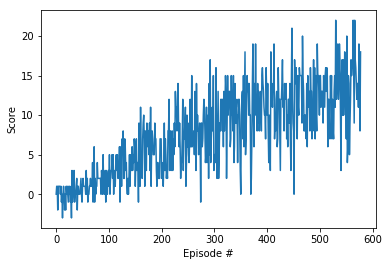

In [20]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()